In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

In [2]:
from eofs.xarray import Eof

In [3]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [4]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [5]:
def regrid_masks(ds):
    #rename coords
    ds = ds.rename({"XT_OCEAN": "longitude", "YT_OCEAN": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    #ds_in_1deg = ds.drop({'XT_OCEAN', 'YT_OCEAN'})
    #create regridder
    regridder_1deg = xe.Regridder(ds, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds)
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [6]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [7]:
%%time
ctrl = regrid_ACCESS(ctrl_sst)

CPU times: user 12.3 s, sys: 1.4 s, total: 13.7 s
Wall time: 16.5 s


In [8]:
ctrl = ctrl.compute()

In [10]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO-SETIO).drop('month')

Lets do a bootstrap approach. I want to sample at random 30 years from the timeseries with replacement. We will then look at whether these 30 year periods are close to the mean of the control, and whether the variance or standard deviation is different from the control. 

In [127]:
n34 = NINO34(ctrl)

In [11]:
DMI = dmi(ctrl)

First test if the DMi is drawn from the normal distribution (probably yes)

In [41]:
import  scipy.stats as stats

In [42]:
stats.shapiro(DMI)

ShapiroResult(statistic=0.9799718856811523, pvalue=6.245952297062369e-18)

In [128]:
stats.shapiro(n34)

ShapiroResult(statistic=0.9910333156585693, pvalue=4.285350546640032e-11)

In [73]:
def bootstrap_index(ds, num_years):
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2: loop over the number of iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select 30 years with replacement
        random_years = np.random.choice(ds['time.year'], size=num_years, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = DMI.sel(time=np.isin(ds['time.year'], random_years))
        std_dev = selected_years_data.std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(selected_years_data)
    return xr.concat(std_deviations, dim = 'it')

In [129]:
dmi_30 = bootstrap_index(n34, 30)
dmi_50 = bootstrap_index(n34, 50)

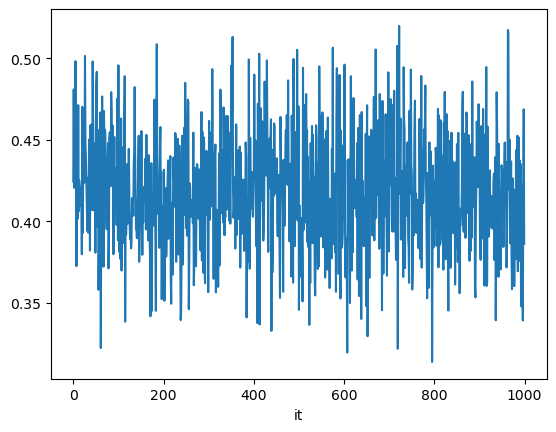

In [137]:
dmi_30.std('time').plot()

(array([ 1.,  2.,  1.,  1.,  1.,  4.,  6.,  7.,  4., 10.,  9., 13., 15.,
        18., 18., 21., 33., 37., 36., 36., 36., 48., 41., 49., 54., 49.,
        47., 39., 34., 46., 34., 34., 30., 30., 30., 17., 24., 17., 11.,
        10.,  9.,  5.,  5.,  9.,  6.,  4.,  3.,  2.,  2.,  2.]),
 array([-0.11077428, -0.10665834, -0.10254241, -0.09842647, -0.09431053,
        -0.09019459, -0.08607866, -0.08196272, -0.07784678, -0.07373085,
        -0.06961491, -0.06549897, -0.06138304, -0.0572671 , -0.05315116,
        -0.04903523, -0.04491929, -0.04080335, -0.03668742, -0.03257148,
        -0.02845554, -0.02433961, -0.02022367, -0.01610773, -0.0119918 ,
        -0.00787586, -0.00375992,  0.00035601,  0.00447195,  0.00858789,
         0.01270382,  0.01681976,  0.0209357 ,  0.02505163,  0.02916757,
         0.03328351,  0.03739944,  0.04151538,  0.04563132,  0.04974725,
         0.05386319,  0.05797913,  0.06209507,  0.066211  ,  0.07032694,
         0.07444288,  0.07855881,  0.08267475,  0.08679069,

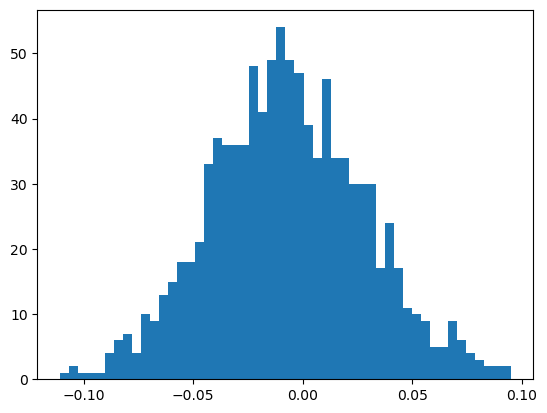

In [141]:
(dmi_30.std('time') - DMI.std('time')).plot.hist(bins = 50)

(array([ 11.,  58., 188., 597., 863., 459., 141.,  62.,  25.,   8.]),
 array([-1.4688089 , -1.1383132 , -0.80781734, -0.4773216 , -0.14682584,
         0.18366992,  0.5141657 ,  0.8446615 ,  1.1751572 ,  1.505653  ,
         1.8361487 ], dtype=float32),
 <BarContainer object of 10 artists>)

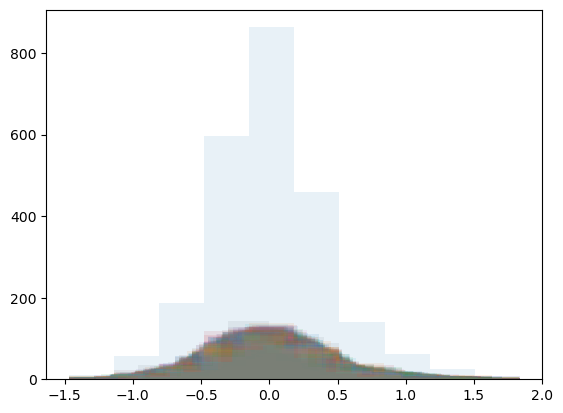

In [76]:
for i in dmi_30.it:
    dmi_30.sel(it=i).plot.hist(alpha = 0.1)
DMI.plot.hist(alpha =0.1)

The above plot indicates that the differnt monte carlo simulations are all drawn from the original timeseires, but do they all fall within 95% confidence of the control?

In [130]:
count = 0
for i in dmi_30.it:
    data1 = dmi_30.sel(it=i)
    stat, pval = stats.levene(DMI.values, data1.dropna(dim = 'time').values)
    if pval < 0.05:
        count = count+1


In [131]:
count

175

In [115]:
data1.groupby('time.month')[2]

<xarray.DataArray (time: 201)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  0.11366834,         nan,
               nan,         nan,  0.35349688,         nan,         nan,
               nan,         nan,         nan,  0.33471555,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,  0.005244  ,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.11750224,         nan,         nan,
        0.05127223,         nan,         nan,  0.19915181,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -0.6359524 , -0.01542163,         nan, -0.28340423,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, -0.00782758,         nan,
...
        0.24997288,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  0.17184071,         nan,
               nan,         nan,  0.15803342,         nan,         nan,
        0.1404946 ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  0.00818497,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  0.03297234,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.08395267,         nan,         nan,
               nan,  0.24964799,         nan, -0.2860107 ,         nan,
               nan,         nan,         nan,         nan, -0.21035391,
               nan,         nan,         nan,         nan,  0.08858398,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.30545986,  0.34301376,         nan, -0.27349424,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.0514873 ,         nan,         nan,         nan,         nan,
               nan], dtype=float32)
Coordinates:
  * time     (time) object 0950-02-15 00:00:00 ... 1150-02-15 00:00:00

In [72]:
DMI.var()

<xarray.DataArray ()>
array(0.18039021)

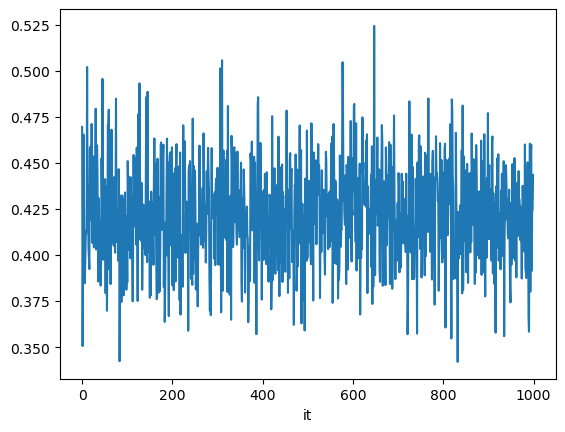

In [71]:
dmi_50.plot()

(array([  1489.,   7910.,  26007.,  82323., 120902.,  64074.,  19508.,
          8591.,   3492.,   1152.]),
 array([-1.4688089 , -1.1383132 , -0.80781734, -0.4773216 , -0.14682584,
         0.18366992,  0.5141657 ,  0.8446615 ,  1.1751572 ,  1.505653  ,
         1.8361487 ], dtype=float32),
 <BarContainer object of 10 artists>)

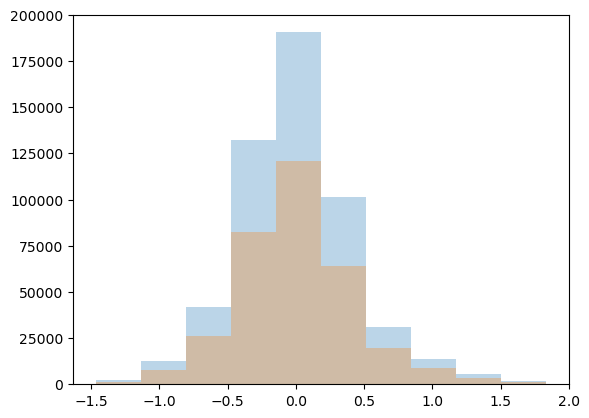

In [64]:
dmi_50.plot.hist(alpha = 0.3)
dmi_30.plot.hist(alpha = 0.3)

(array([ 11.,  58., 188., 597., 863., 459., 141.,  62.,  25.,   8.]),
 array([-1.4688089 , -1.1383132 , -0.80781734, -0.4773216 , -0.14682584,
         0.18366992,  0.5141657 ,  0.8446615 ,  1.1751572 ,  1.505653  ,
         1.8361487 ], dtype=float32),
 <BarContainer object of 10 artists>)

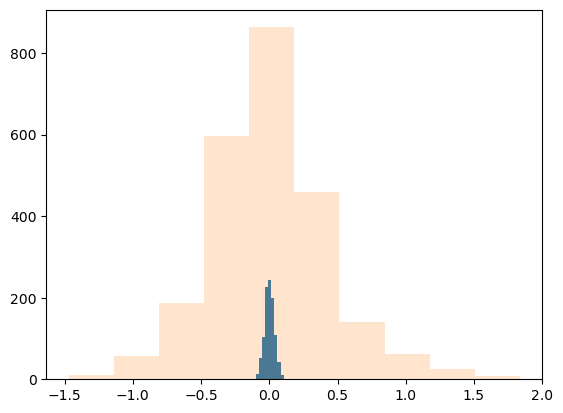

In [61]:
dmi_50.mean('time').plot.hist()
DMI.plot.hist(alpha = 0.2)

In [36]:
DMI.quantile([0.05, 0.95], dim = 'time')

<xarray.DataArray (quantile: 2)>
array([-0.66183805,  0.76175902])
Coordinates:
  * quantile  (quantile) float64 0.05 0.95

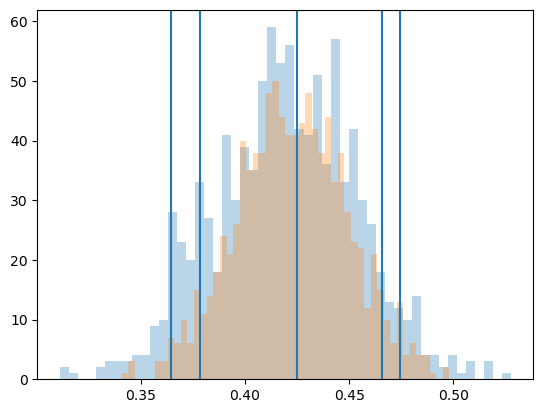

In [40]:
dmi_30.plot.hist(bins = 50,alpha = .30)
dmi_50.plot.hist(bins = 50, alpha = .30)
plt.axvline(DMI.std())
plt.axvline(dmi_30.quantile([0.05, 0.95], dim = 'it')[0])
plt.axvline(dmi_30.quantile([0.05, 0.95], dim = 'it')[1])
plt.axvline(dmi_50.quantile([0.05, 0.95], dim = 'it')[0])
plt.axvline(dmi_50.quantile([0.05, 0.95], dim = 'it')[1])

In [17]:
def TS_window(da, leng):
    rnge = len(da.time) - leng
    val_list=[]
    for i in range(0,rnge,1):
        start = i*12
        end = start + (12*leng)
        arr = da[start:end].std('time')
        #std_dev.append(arr)
        #print(DMI[start].dt.year)
        da = xr.DataArray(
            data=arr,

            dims=None,

            coords=dict(
                time=950+i,
            ),

            attrs=dict(

                description="standard deviation DMI for 10 year window",

                units="degC",

            ),

        )
        if i ==0:
            da1 =da
        if i >0:
            da1 = xr.concat([da1, da], dim = 'time')
    return da1

In [18]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO-SETIO).drop('month')

In [19]:
def create_moving_windows(da, len_window = 50):
    """
    Selects moving 50-year windows from an xarray DataArray with monthly time steps.
    Consective years

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(0, int(len(da.time)/12)-len_window, 1):
        start_date = cftime.DatetimeGregorian(start_year, 1, 1)
        end_date = cftime.DatetimeGregorian(start_year + len_window, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        #window = window.std('time')
        windows.append(window)
        start_year = start_year+1

    return windows

In [20]:
import random
import cftime

def select_random_windows(da, num_windows=10, len_window = 50):
    """
    Selects random 50-year windows from an xarray DataArray with monthly time steps.

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(num_windows):
        start = random.randint(start_year, end_year)
        start_date = cftime.DatetimeGregorian(start, 1, 1)
        end_date = cftime.DatetimeGregorian(start + len_window, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        #window = window.std('time')
        windows.append(window)
    return windows

In [21]:
def SH_mn(DS):
    return ssta(DS).sel(latitude=slice(-60, 0)).mean(['latitude', 'longitude'])
def NH_mn(DS):
    return ssta(DS).sel(latitude=slice(0, 60)).mean(['latitude', 'longitude'])

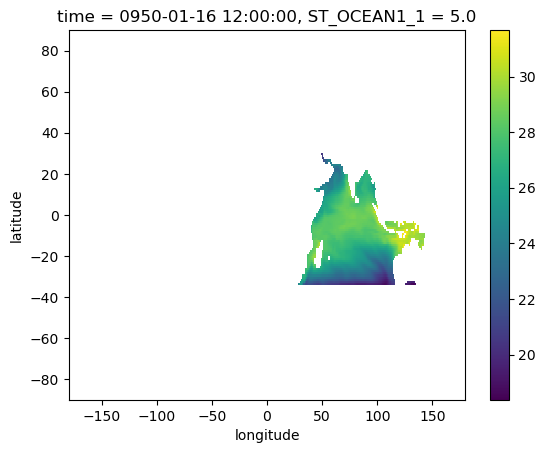

In [22]:
ctrl.where(IO == 5)[0].plot()

In [23]:
def IO_basin(DS):
    return DS.where(IO == 5).mean(['latitude', 'longitude'])

In [24]:
def PO_basin(DS):
    return DS.where(PO == 3).mean(['latitude', 'longitude'])

In [25]:
def AO_basin(DS):
    return DS.where(AO == 2).mean(['latitude', 'longitude'])

In [26]:
#lets define the DMI and Nino24 indexes

(array([  26050.,  130794.,  273489.,  513176.,  800325., 1173387.,
        2034742., 3283485.,  597274.,   14494.]),
 array([12.405912, 14.558578, 16.711243, 18.863907, 21.016573, 23.169239,
        25.321903, 27.474567, 29.627234, 31.7799  , 33.932564],
       dtype=float32),
 <BarContainer object of 10 artists>)

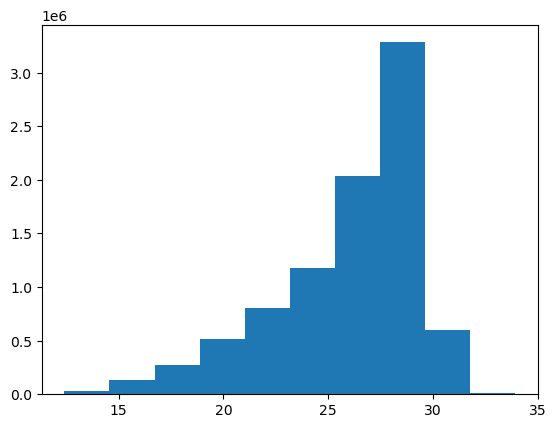

In [27]:
plt.hist(ctrl.where(IO == 5).values.flatten())

In [28]:
IO_sst = IO_basin(ctrl)
PO_sst = PO_basin(ctrl)
AO_sst = AO_basin(ctrl)

In [29]:
DMI = dmi(ctrl)

In [30]:
N34 = NINO34(ctrl).drop('month')

In [31]:
SH = SH_mn(ctrl)

In [32]:
NH = NH_mn(ctrl)

In [33]:
DMI

<xarray.DataArray (time: 2412)>
array([0.18244019, 0.08512398, 0.1274277 , ..., 0.82120407, 0.37125218,
       0.13151374], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00

In [34]:
N34

<xarray.DataArray (time: 2412)>
array([ 0.13570707,  0.3107048 ,  0.0277136 , ..., -0.25847846,
       -0.34881207, -0.58449   ], dtype=float32)
Coordinates:
  * time     (time) object 0950-01-16 12:00:00 ... 1150-12-16 12:00:00

In [35]:
DMI_10s = create_moving_windows(DMI, len_window=10)
DMI_50s = create_moving_windows(DMI, len_window=50)
DMI_90s = create_moving_windows(DMI, len_window=90)


In [38]:
stat_sig_windows_TT(DMI_90s)

NameError: name 'stat_sig_windows_TT' is not defined

In [ ]:
aaa

In [37]:
from scipy.stats import ttest_ind, ranksums

In [39]:
def create_consec_winds(da, len_window = 50):
    """
    Selects random 50-year windows from an xarray DataArray with monthly time steps.

    Args:
        da (xarray.DataArray): The data array to select windows from.
        num_windows (int): The number of windows to select.
        len_window (int): length of window in years

    Returns:
        A list of xarray DataArray objects, each containing a 50-year window of the original data.
    """
    windows = []
    start_year = da.time.dt.year.min().data
    end_year = da.time.dt.year.max().data - len_window
    for i in range(0, int(len(da.time)/12/len_window), 1):
        start_date = cftime.DatetimeGregorian(start_year, 1, 1)
        end_date = cftime.DatetimeGregorian(start_year + len_window -1, 12, 31)
        window = da.sel(time=slice(start_date, end_date))
        #window = window.std('time')
        windows.append(window)
        start_year = start_year+len_window

    return windows

In [40]:
from scipy.special import comb

In [41]:
def stat_sig_windows_TT(inp_list):
    statsig=[]
    for i in range(len(inp_list)):
        for j in range(i+1, len(inp_list)):
            data1 = inp_list[i].values
            data2 = inp_list[j].values
            stat, pval = ttest_ind(data1, data2)
            if pval < 0.05:
                statsig.append([i+1, j+1])
    if statsig:
        len_windows = len(inp_list)
        no_periods  = len(statsig)
        total_comb = comb(len_windows,2)
        print(f"There is {no_periods} combinations of {total_comb} total combinations of {len_windows} periods significantly different from each other")
    return

In [42]:
def stat_sig_windows_WRS(inp_list):
    statsig=[]
    for i in range(len(inp_list)):
        for j in range(i+1, len(inp_list)):
            data1 = inp_list[i].values
            data2 = inp_list[j].values
            stat, pval = ranksums(data1, data2)
            if pval < 0.05:
                statsig.append([i+1, j+1])
    if statsig:
        len_windows = len(inp_list)
        no_periods  = len(statsig)
        total_comb = comb(len_windows,2)
        print(f"There is {no_periods} combinations of {total_comb} total combinations of {len_windows} periods significantly different from each other")
    return

In [43]:
def test_movingwindows_TT(TS):
    TS_10s = create_moving_windows(TS, len_window=10)
    TS_20s = create_moving_windows(TS, len_window=20)
    TS_30s = create_moving_windows(TS, len_window=30)
    TS_40s = create_moving_windows(TS, len_window=40)
    TS_50s = create_moving_windows(TS, len_window=50)
    TS_60s = create_moving_windows(TS, len_window=60)
    TS_70s = create_moving_windows(TS, len_window=70)
    TS_80s = create_moving_windows(TS, len_window=80)
    TS_90s = create_moving_windows(TS, len_window=90)
    #now print stat significance for window
    print("Checking 10 year windows")
    stat_sig_windows_TT(TS_10s)
    print("Checking 20 year windows")
    stat_sig_windows_TT(TS_20s)
    print("Checking 30 year windows")
    stat_sig_windows_TT(TS_30s)
    print("Checking 40 year windows")
    stat_sig_windows_TT(TS_40s)
    print("Checking 50 year windows")
    stat_sig_windows_TT(TS_50s)
    print("Checking 60 year windows")
    stat_sig_windows_TT(TS_60s)
    print("Checking 70 year windows")
    stat_sig_windows_TT(TS_70s)
    print("Checking 80 year windows")
    stat_sig_windows_TT(TS_80s)
    print("Checking 90 year windows")
    stat_sig_windows_TT(TS_90s)
    return

In [44]:
test_movingwindows_TT(DMI)

Checking 10 year windows
There is 7993 combinations of 18145.0 total combinations of 191 periods significantly different from each other
Checking 20 year windows
There is 6080 combinations of 16290.0 total combinations of 181 periods significantly different from each other
Checking 30 year windows
There is 3093 combinations of 14535.0 total combinations of 171 periods significantly different from each other
Checking 40 year windows
There is 1854 combinations of 12880.0 total combinations of 161 periods significantly different from each other
Checking 50 year windows
There is 944 combinations of 11325.0 total combinations of 151 periods significantly different from each other
Checking 60 year windows
There is 667 combinations of 9870.0 total combinations of 141 periods significantly different from each other
Checking 70 year windows
There is 444 combinations of 8515.0 total combinations of 131 periods significantly different from each other
Checking 80 year windows
There is 96 combinati

In [45]:
test_movingwindows_TT(IO_sst)

Checking 10 year windows
There is 7 combinations of 18145.0 total combinations of 191 periods significantly different from each other
Checking 20 year windows
There is 37 combinations of 16290.0 total combinations of 181 periods significantly different from each other
Checking 30 year windows
There is 151 combinations of 14535.0 total combinations of 171 periods significantly different from each other
Checking 40 year windows
There is 406 combinations of 12880.0 total combinations of 161 periods significantly different from each other
Checking 50 year windows
There is 445 combinations of 11325.0 total combinations of 151 periods significantly different from each other
Checking 60 year windows
There is 342 combinations of 9870.0 total combinations of 141 periods significantly different from each other
Checking 70 year windows
There is 218 combinations of 8515.0 total combinations of 131 periods significantly different from each other
Checking 80 year windows
There is 90 combinations of 

In [46]:
test_movingwindows_TT(N34)

Checking 10 year windows
There is 4497 combinations of 18145.0 total combinations of 191 periods significantly different from each other
Checking 20 year windows
There is 2517 combinations of 16290.0 total combinations of 181 periods significantly different from each other
Checking 30 year windows
There is 832 combinations of 14535.0 total combinations of 171 periods significantly different from each other
Checking 40 year windows
There is 284 combinations of 12880.0 total combinations of 161 periods significantly different from each other
Checking 50 year windows
There is 130 combinations of 11325.0 total combinations of 151 periods significantly different from each other
Checking 60 year windows
There is 110 combinations of 9870.0 total combinations of 141 periods significantly different from each other
Checking 70 year windows
Checking 80 year windows
There is 46 combinations of 7260.0 total combinations of 121 periods significantly different from each other
Checking 90 year windows

In [47]:
def test_windows_TT(TS):
    TS_10s = create_consec_winds(TS, len_window=10)
    TS_20s = create_consec_winds(TS, len_window=20)
    TS_30s = create_consec_winds(TS, len_window=30)
    TS_40s = create_consec_winds(TS, len_window=40)
    TS_50s = create_consec_winds(TS, len_window=50)
    #now print stat significance for window
    print("Checking 10 year windows")
    stat_sig_windows_TT(TS_10s)
    print("Checking 20 year windows")
    stat_sig_windows_TT(TS_20s)
    print("Checking 30 year windows")
    stat_sig_windows_TT(TS_30s)
    print("Checking 40 year windows")
    stat_sig_windows_TT(TS_40s)
    print("Checking 50 year windows")
    stat_sig_windows_TT(TS_50s)
    return

In [48]:
def test_windows_WRS(TS):
    TS_10s = create_consec_winds(TS, len_window=10)
    TS_20s = create_consec_winds(TS, len_window=20)
    TS_30s = create_consec_winds(TS, len_window=30)
    TS_40s = create_consec_winds(TS, len_window=40)
    TS_50s = create_consec_winds(TS, len_window=50)
    #now print stat significance for window
    print("Checking 10 year windows")
    stat_sig_windows_WRS(TS_10s)
    print("Checking 20 year windows")
    stat_sig_windows_WRS(TS_20s)
    print("Checking 30 year windows")
    stat_sig_windows_WRS(TS_30s)
    print("Checking 40 year windows")
    stat_sig_windows_WRS(TS_40s)
    print("Checking 50 year windows")
    stat_sig_windows_WRS(TS_50s)
    return

In [49]:
test_windows_TT(AO_sst)

Checking 10 year windows
There is 1 combinations of 190.0 total combinations of 20 periods significantly different from each other
Checking 20 year windows
Checking 30 year windows
Checking 40 year windows
Checking 50 year windows


In [50]:
test_windows_TT(IO_sst)

Checking 10 year windows
Checking 20 year windows
Checking 30 year windows
Checking 40 year windows
Checking 50 year windows


In [51]:
test_windows_TT(PO_sst)

Checking 10 year windows
There is 12 combinations of 190.0 total combinations of 20 periods significantly different from each other
Checking 20 year windows
There is 6 combinations of 45.0 total combinations of 10 periods significantly different from each other
Checking 30 year windows
There is 2 combinations of 15.0 total combinations of 6 periods significantly different from each other
Checking 40 year windows
Checking 50 year windows


In [52]:
test_windows_TT(DMI)

Checking 10 year windows
There is 91 combinations of 190.0 total combinations of 20 periods significantly different from each other
Checking 20 year windows
There is 21 combinations of 45.0 total combinations of 10 periods significantly different from each other
Checking 30 year windows
There is 7 combinations of 15.0 total combinations of 6 periods significantly different from each other
Checking 40 year windows
Checking 50 year windows


In [53]:
test_windows_TT(N34)

Checking 10 year windows
There is 50 combinations of 190.0 total combinations of 20 periods significantly different from each other
Checking 20 year windows
There is 10 combinations of 45.0 total combinations of 10 periods significantly different from each other
Checking 30 year windows
There is 5 combinations of 15.0 total combinations of 6 periods significantly different from each other
Checking 40 year windows
Checking 50 year windows


In [54]:
test_windows_TT(N34)

Checking 10 year windows
There is 50 combinations of 190.0 total combinations of 20 periods significantly different from each other
Checking 20 year windows
There is 10 combinations of 45.0 total combinations of 10 periods significantly different from each other
Checking 30 year windows
There is 5 combinations of 15.0 total combinations of 6 periods significantly different from each other
Checking 40 year windows
Checking 50 year windows


In [ ]:
######Let's analyse the SST products we might beusing

In [55]:
#load observational SST
oiv2 = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2.nc", chunks = {'time':12}).sst
#rename coords
oiv2 = oiv2.rename({"lon": "longitude", "lat": "latitude"})
oiv2 = oiv2.compute()
#load the lsm
lsm = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2_lsm.nc").mask
#rename coords
lsm = lsm.rename({"lon": "longitude", "lat": "latitude"})
oiv2 = oiv2.where(lsm[0]==1)
oiv2 = oiv2.sel(time = slice("1980-01-01", "2020-12-31"))

In [56]:
#load observational SST
ersstv5 = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ersstv5.nc", chunks = {'time':12}).sst
#rename coords
ersstv5 = ersstv5.rename({"lon": "longitude", "lat": "latitude"})
#ersstv5 =ersstv5.sel(time = slice("1981-12-01", "2020-12-31"))
ersstv5 = ersstv5.compute()

In [57]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/HadISST.nc", chunks = {'time':12}).sst
#rename coords
hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
#hadsst =hadsst.sel(time = slice("1981-12-01", "2020-12-31"))
hadsst = hadsst.compute()

In [58]:
oiv2C = oiv2.groupby('time.month').mean('time')
ersstv5C = ersstv5.groupby('time.month').mean('time')
hadsstC = hadsst.groupby('time.month').mean('time')

In [68]:
TS = hadsst[:, 40,20]

In [60]:
from scipy.signal import detrend

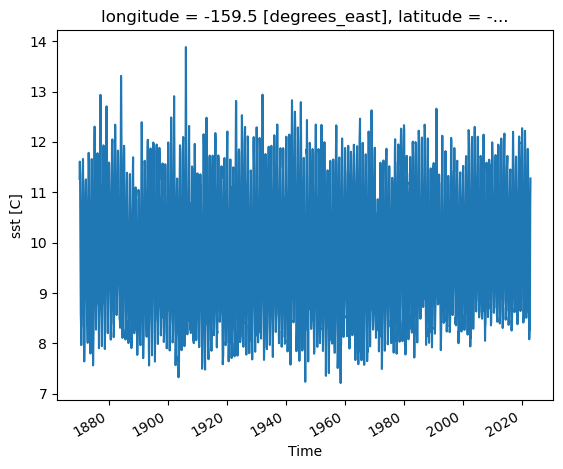

In [61]:
TS.plot()

In [62]:
TS1 = (TS.groupby('time.month') - TS.groupby('time.month').mean('time')).drop('month')

In [63]:
p = TS1.polyfit(dim = 'time', deg = 1)

In [76]:
 xr.polyval(TS1['time'])

TypeError: polyval() missing 1 required positional argument: 'coeffs'

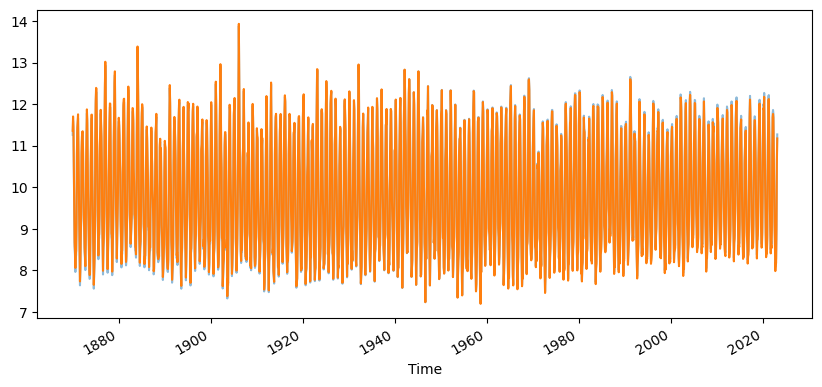

In [64]:
plt.figure(figsize = (10,4))
TS.plot(alpha = 0.5)
#xr.polyval(TS['time'], p.polyfit_coefficients).plot()
(TS - xr.polyval(TS1['time'], p.polyfit_coefficients)).plot()

In [65]:
Had_PO = hadsst.where(BASINS ==3)[:,:,:,0]

In [66]:
Had_PO

<xarray.DataArray 'sst' (time: 1837, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1870-01-16T12:00:00 ... 2023-01-16T12:...
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    ST_OCEAN1_1  float64 5.0
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [67]:
def detrend_dim(da, dim, deg=1):
    #detrend the anomaly
    daa = (da.groupby('time.month') - da.groupby('time.month').mean('time')).drop('month')
    # detrend along a single dimension
    p = daa.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(daa[dim], p.polyfit_coefficients)
    return fit

In [62]:
test = detrend_dim(Had_PO, dim = "time")

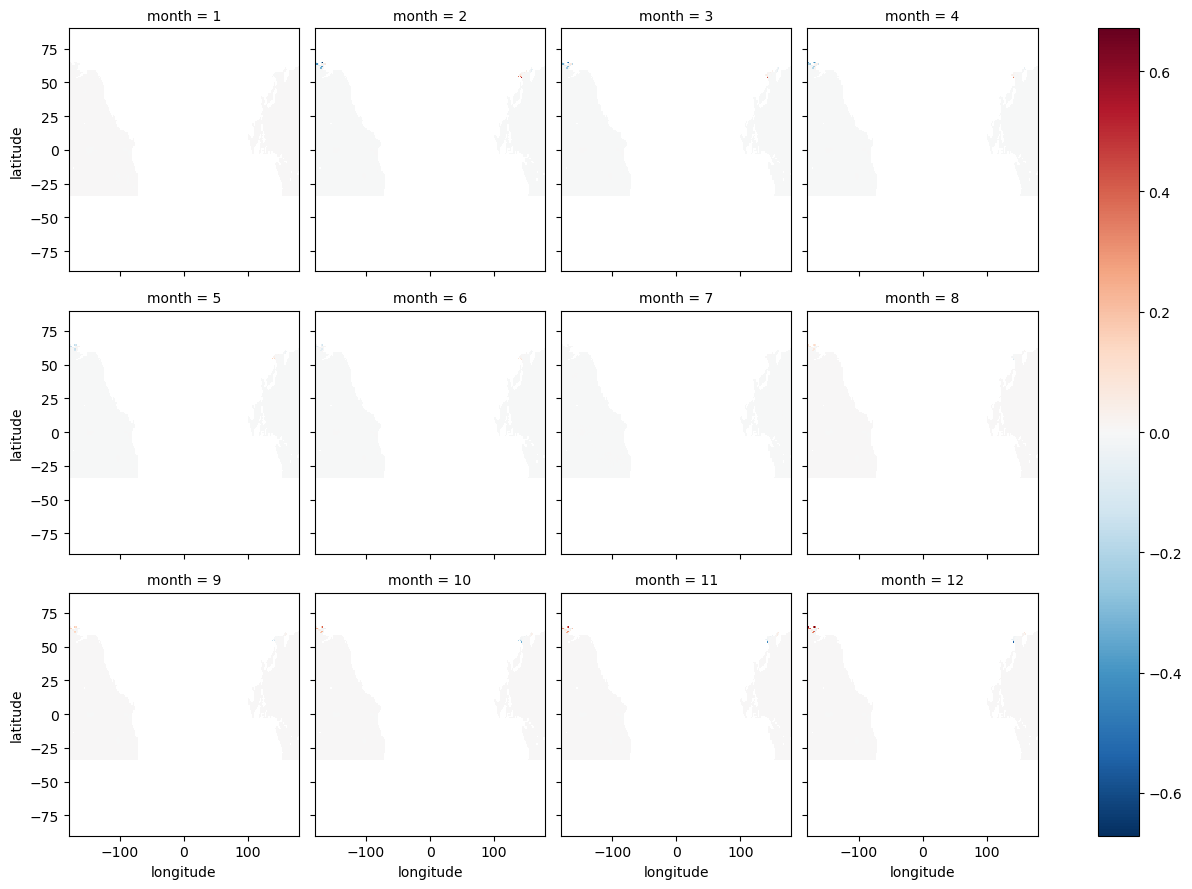

In [65]:
test.groupby('time.month').mean('time').plot(col = 'month', col_wrap = 4)

In [69]:
test

<xarray.DataArray (time: 1837, latitude: 180, longitude: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 1870-01-16T12:00:00 ... 2023-01-16T12:...
    ST_OCEAN1_1  (time) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
  * latitude     (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude    (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5

In [70]:
test.groupby(['latitude', 'longitude']).mean(dim='time')

TypeError: `group` must be an xarray.DataArray or the name of an xarray variable or dimension. Received ['latitude', 'longitude'] instead.

In [ ]:
print('foo')

In [ ]:
for i in range(-25, 24,1):
    for j in range(-180,179, 1):
        try:
            test.sel(latitude=slice(i,i+1), longitude=slice(j,j+1)).plot()
        except:
            print("no lat lon")


no lat lon


Process Dask Worker process (from Nanny):
2023-03-23 15:35:58,394 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-03-23 15:35:58,398 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/nanny

no lat lon


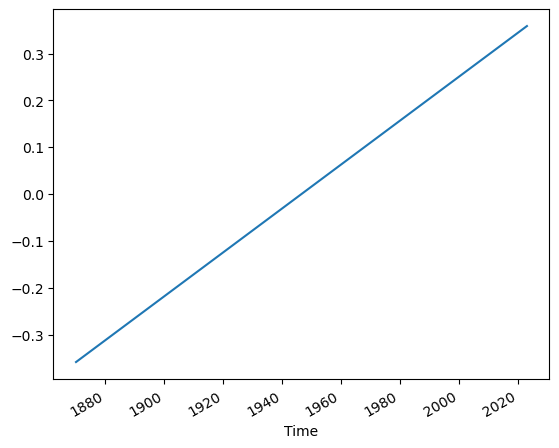

In [64]:
test.mean(['latitude', 'longitude']).plot()

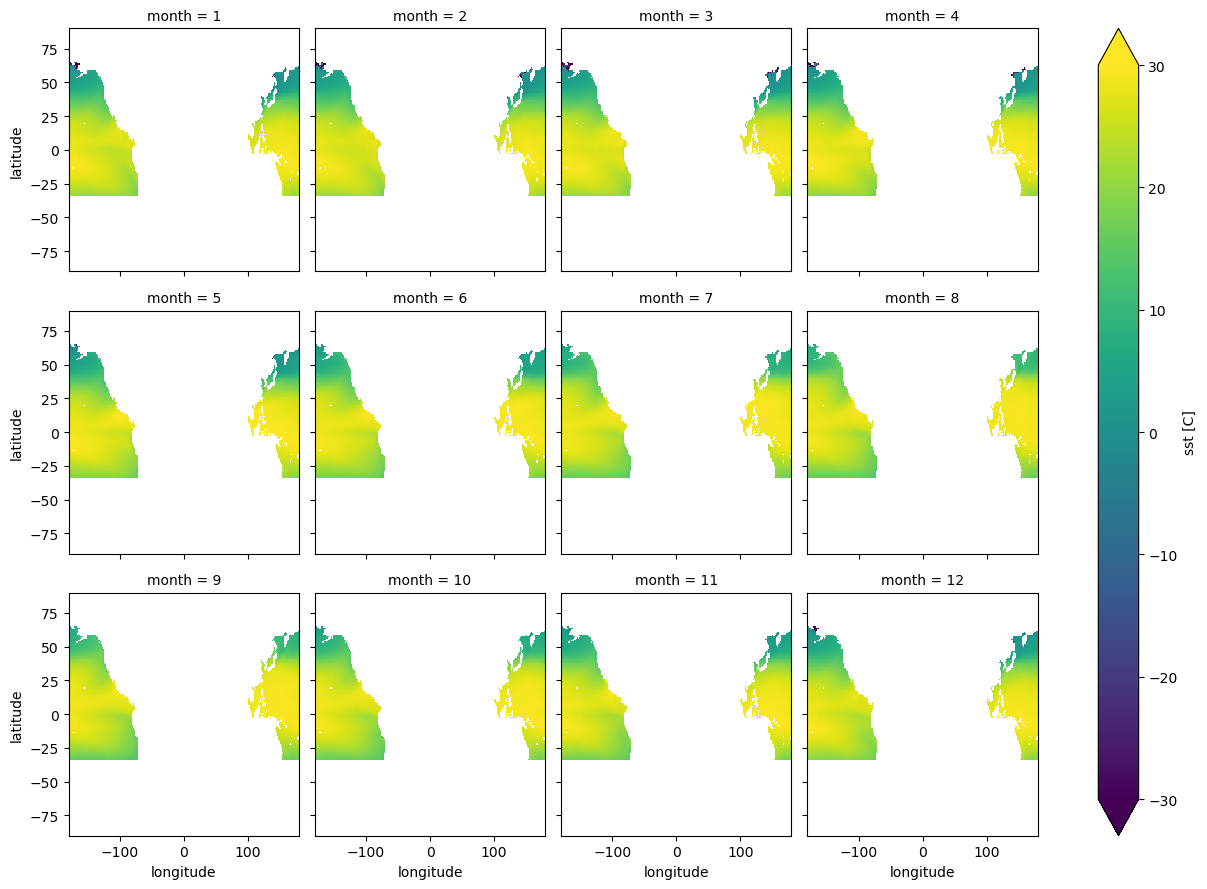

In [58]:
Had_PO.groupby('time.month').mean('time').plot(col = 'month', col_wrap = 4, vmin = -30, vmax = 30)

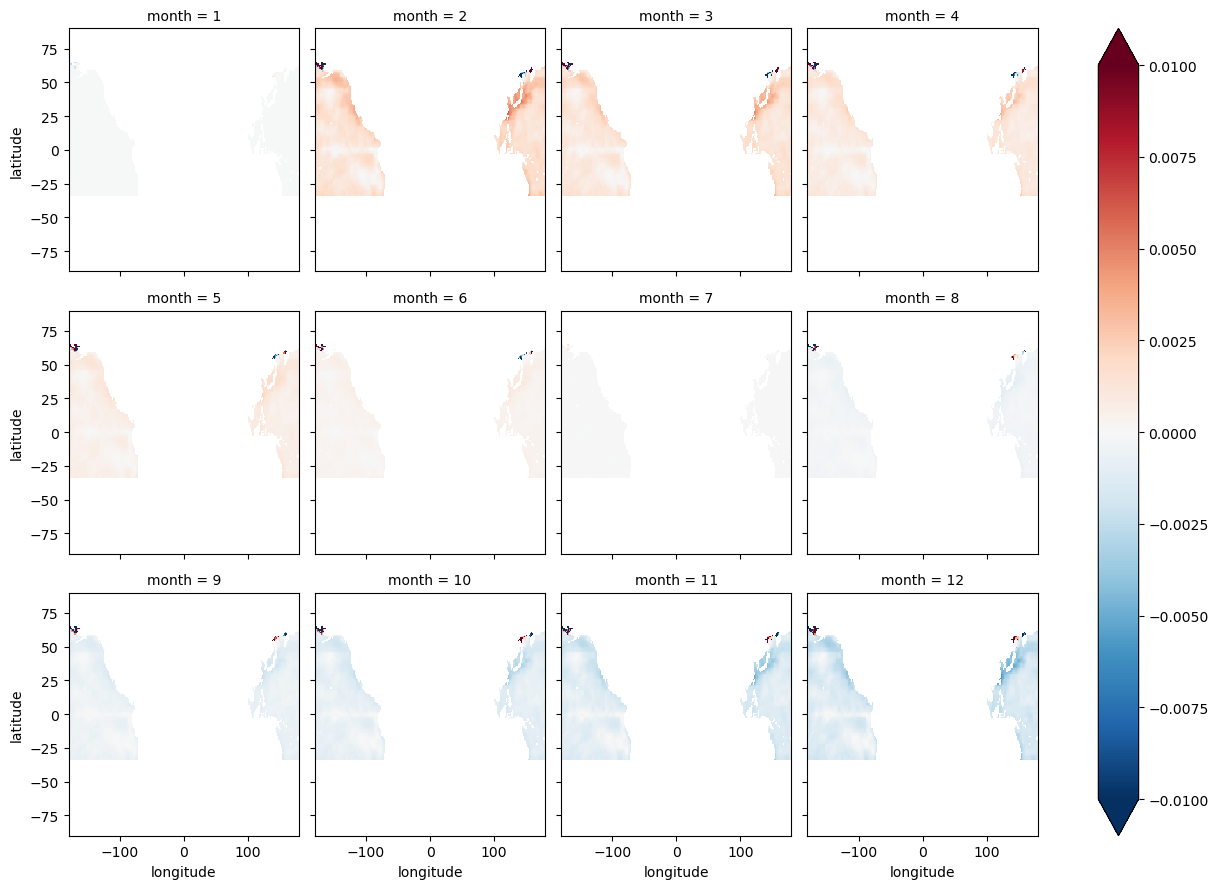

In [60]:
(test.groupby('time.month').mean('time') -Had_PO.groupby('time.month').mean('time') ).plot(col = 'month', col_wrap = 4, vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')

In [63]:
#now create an obs timeseries of these 

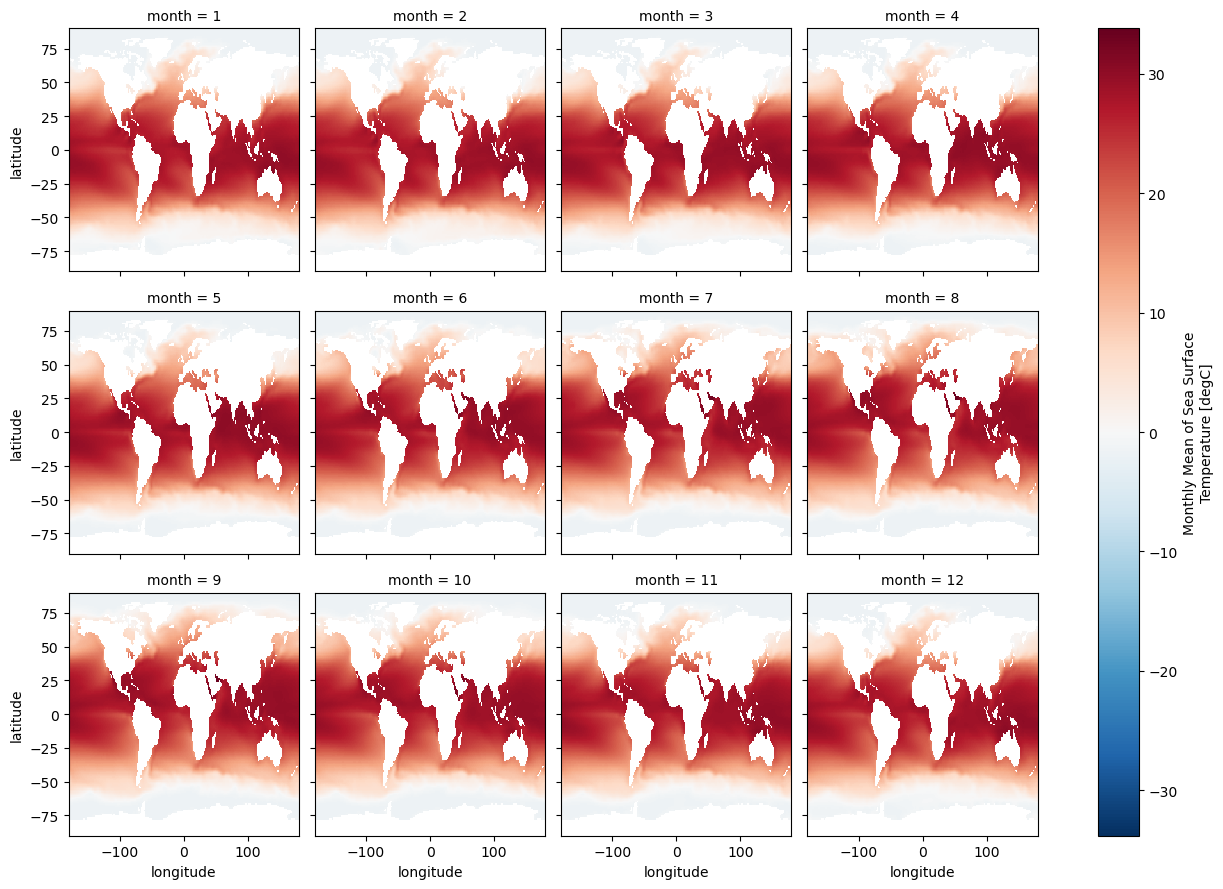

In [70]:
oiv2C.plot(col = 'month', col_wrap = 4)

In [64]:
OBS = xr.concat([oiv2C, ersstv5C, hadsstC], dim = 'model')

/local/e14/sm2435/tmp/ipykernel_2650214/3473350824.py:4: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(fg.axes.flat):


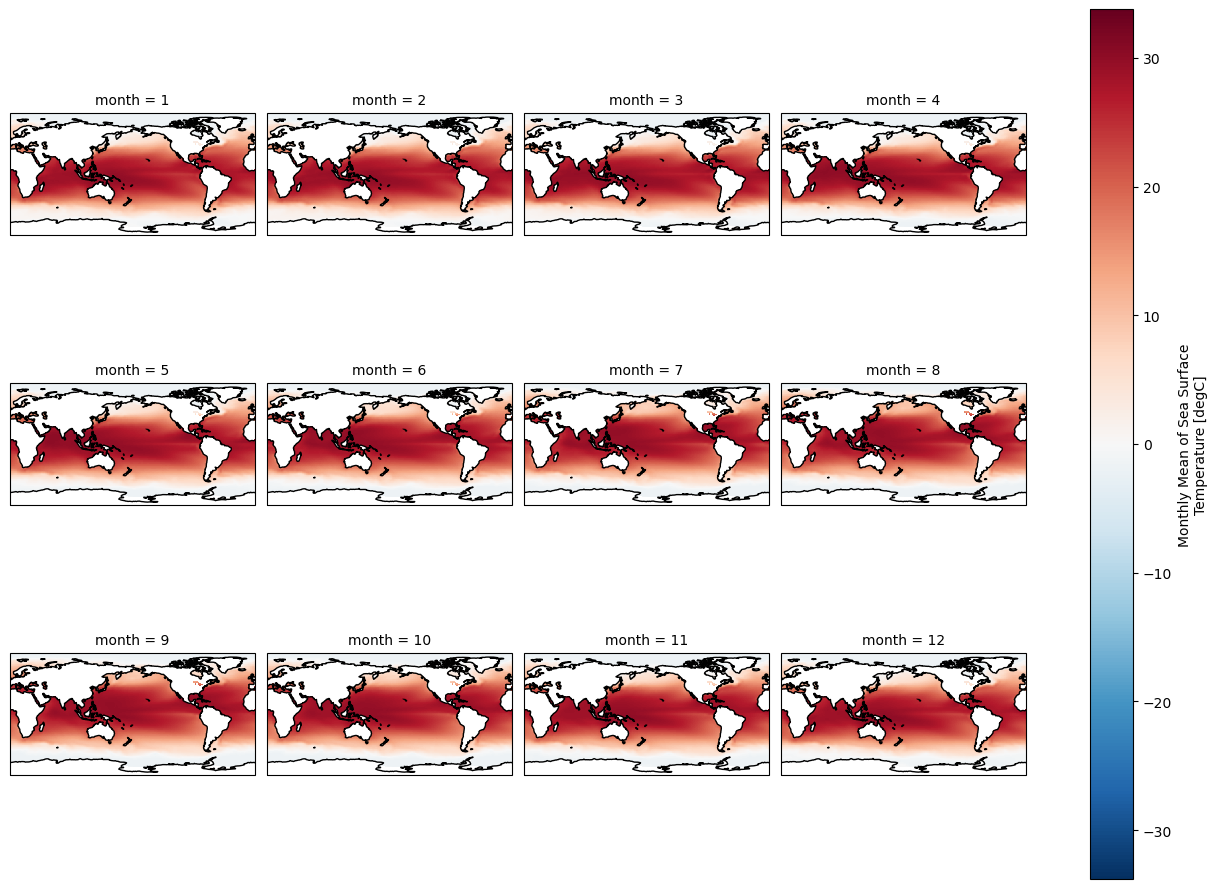

In [76]:
fg = oiv2C.plot(transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180)},
                           col = 'month', col_wrap = 4)
for i, ax in enumerate(fg.axes.flat):
    ax.coastlines()

In [60]:
oiv2

<xarray.DataArray 'sst' (time: 469, latitude: 180, longitude: 360)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
...
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79],
        [-1.79, -1.79, -1.79, ..., -1.79, -1.79, -1.79]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2020-12-01
  * longitude  (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    standard_name:         sea_surface_temperature
    long_name:             Monthly Mean of Sea Surface Temperature
    units:                 degC
    unpacked_valid_range:  [-5. 40.]
    actual_range:          [-1.7999996 35.56862  ]
    precision:             2
    var_desc:              Sea Surface Temperature
    dataset:               NOAA Optimum Interpolation (OI) SST V2
    level_desc:            Surface
    statistic:             Mean
    parent_stat:           Weekly Mean
    cell_methods:          time: mean (monthly from weekly values interpolate...